# Bias Frame Calibration

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tifffile import imsave

import sys
sys.path.append('../tauSWIRcamera')  # Add the path to the directory containing file_to_import.py
from tauSWIRcamera import tauSWIRcamera

plt.rcParams["font.family"] = "Times New Roman"

In [2]:
hostname = '129.123.5.125'
port = 4000
cam = tauSWIRcamera(hostname, port)
cameraFolder = cam.name
hist_color = {"low": "green", "medium": "blue", "high": "red" }

## START CAMERA SETUP ##
1. Analog mode set to: DISABLED
2. External Sync Mode set to: DISABLED
3. AGC set to: MANUAL
4. Auto-Exposure set to: DISABLED
5. CMOS bit depth set to: 14-BITS
6. Camera Link bit depth set to: 14-BITS
7. Integration mode set to: UNRESTRICTED
8. FPA Set Point Temperature set to: 20oC
9. Settings set as Power-on Default
## CAMERA SETUP COMPLETED ##


## Data Acquisition

Running setup script - Gain Mode: high
Gain set to: high - Wellsize: 41000.0 e-
Int. Time set to: 0.01ms
Previous TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
New TEC parameters:
TEC is ON
FPA set point temperature (oC): 40
.urrent temp (oC): 39.4, Set-point: 40 - delta: -0.6 ...  ................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................... 


/var/folders/t5/1zdfp4m52kqbs2csdsp2625c0000gn/T/ipykernel_45679/2101417349.py:19: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(f'{cameraFolder}/raw_images_stack_{gainMode}_{FPA_setPointTemp}C_{cameraFolder}.tif', df)


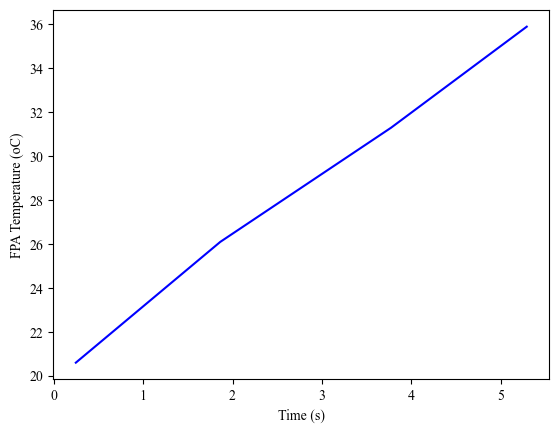

In [116]:
### Set gain ###
gainMode = "high"
cam.setSensorGain(gainMode)

# Set the shortest integration time (003E)
shortest_intTime_ms = 0.011 # 3E-> 62, intTime_ms = 62/5704.807
cam.setIntTime(shortest_intTime_ms)

# Set FPA temperature to 20C
FPA_setPointTemp = 40
FPA_temp_setpoint_options = [0, 20, 40, 45] #oC
cam.setFPATempSetPoint(FPA_temp_setpoint_options.index(FPA_setPointTemp),plot=True)

# Collect frames
N = 500
df = cam.collectFrame(N)

# Save the stack of images as a multi-page TIFF file
imsave(f'{cameraFolder}/raw_images_stack_{gainMode}_{FPA_setPointTemp}C_{cameraFolder}.tif', df)


### Compute Statistics and save Mean and Std frames 

In [117]:
# Compute average bias frame
bias_frame_mean = np.mean(df, axis=0)
# Save bias frame
bias_frame_mean_unit16 = bias_frame_mean.astype(np.uint16)
image = Image.fromarray(bias_frame_mean_unit16) # Convert the numpy array to an image
image.save(f'{cameraFolder}/bias_frame_{gainMode}_{FPA_setPointTemp}C_{cameraFolder}.tif')

# Compute average bias frame
bias_frame_std = np.std(df, axis=0)
# Save bias frame std
bias_frame_std_unit16 = bias_frame_std.astype(np.uint16)
image = Image.fromarray(bias_frame_std_unit16) # Convert the numpy array to an image
image.save(f'{cameraFolder}/bias_frame_std_{gainMode}_{FPA_setPointTemp}C_{cameraFolder}.tif')

# Print statistics
# Open the file in write mode
with open(f"{cameraFolder}/bias_frame_statistics_{gainMode}_{FPA_setPointTemp}C_{cameraFolder}", 'w') as f:
    # Write some information to the file
    f.write(f'Mean of Mean Frame: {np.mean(bias_frame_mean)}\n')
    f.write(f'Std of Mean Frame: {np.std(bias_frame_mean)}\n')
    f.write(f'Mean of Std of Pixels: {np.mean(bias_frame_std)}\n')
    f.write(f'Max of Std of Pixels: {np.max(bias_frame_std)}\n')
    f.write(f'Min of Std of Pixels: {np.max(bias_frame_std)}\n')



### Histogram plot 

Pixel coordinates and values outside the clip range:
(582, 0) - Mean value: 913.394 +/- 59.450271353459755
(46, 1) - Mean value: 837.32 +/- 51.9997846149386
(26, 2) - Mean value: 909.602 +/- 52.20045589839224
(40, 2) - Mean value: 903.868 +/- 27.64457588750456
(46, 2) - Mean value: 838.928 +/- 58.41724759007392
(64, 2) - Mean value: 888.09 +/- 53.8075635947215
(152, 2) - Mean value: 910.536 +/- 43.93486888565848
(490, 2) - Mean value: 858.904 +/- 56.97787977803319
(554, 2) - Mean value: 906.178 +/- 64.25071451742781
(626, 2) - Mean value: 917.106 +/- 55.28503200686417
(60, 3) - Mean value: 895.128 +/- 71.00563087530455
(637, 3) - Mean value: 906.096 +/- 68.9722464763908
(13, 4) - Mean value: 905.162 +/- 18.703789883336473
(80, 4) - Mean value: 883.382 +/- 75.24929286046478
(584, 4) - Mean value: 889.718 +/- 36.6240150174718
(22, 5) - Mean value: 892.224 +/- 20.43795058218904
(86, 5) - Mean value: 918.316 +/- 31.878521672122773
(94, 5) - Mean value: 877.414 +/- 48.10445513671264
(635, 5

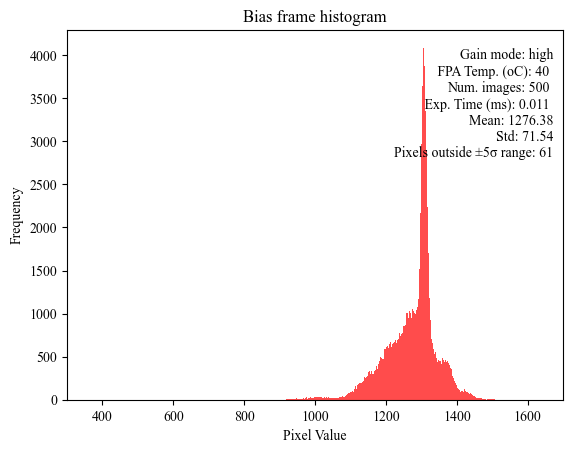

In [118]:

img = bias_frame_mean
# Calculate mean and standard deviation
mean_value = np.mean(img)
std_value = np.std(img)

# Clip the histogram around mean ± 5 * standard deviation
clip_range = (mean_value - 5 * std_value, mean_value + 5 * std_value)

# Histogram xaxis range
hist_range = [300, 1700]

# Find pixel coordinates outside the clip range
pixel_coords = np.where((img < clip_range[0]) | (img > clip_range[1]))

# Print the coordinates and corresponding pixel values outside the clip range
print("Pixel coordinates and values outside the clip range:")
for y, x in zip(pixel_coords[0], pixel_coords[1]):
    pixel_value = img[y, x]
    pixel_value_std = bias_frame_std[y,x]
    print(f"({x}, {y}) - Mean value: {pixel_value} +/- {pixel_value_std}")

# Find pixel coordinates outside the clip range
pixel_coords = np.where((img < clip_range[0]) | (img > clip_range[1]))

# Count the number of pixels outside the clipped range
pixels_outside_range = np.sum((img < clip_range[0]) | (img > clip_range[1]))

with open(f"{cameraFolder}/bias_frame_statistics_{gainMode}_{FPA_setPointTemp}C_{cameraFolder}", 'a') as f:
    # Append some information to the file
    f.write(f'Number of pixels outside +/- 5sigma range: {pixels_outside_range}\n')
    for y, x in zip(pixel_coords[0], pixel_coords[1]):
        f.write(f'({x}, {y}) - Mean value: {pixel_value} +/- {pixel_value_std}\n')

## Histogram
plt.figure()
# Create the histogram
hist, bins, _ = plt.hist(img.flatten(), bins=1000, range=clip_range, density=False, color=hist_color[gainMode], alpha=0.7)
plt.xlim(hist_range)  # Adjust the limits as needed

# Display the mean and standard deviation
plt.text(0.98, 0.80, f'Gain mode: {gainMode}\n FPA Temp. (oC): {FPA_setPointTemp} \nNum. images: {N} \n Exp. Time (ms): {0.011} \nMean: {mean_value:.2f}\nStd: {std_value:.2f}\nPixels outside ±5σ range: {pixels_outside_range}', horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# Set the title and labels
plt.title('Bias frame histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Save the plot as a PDF file
plt.savefig(f'{cameraFolder}/bias_histogram_{gainMode}_{FPA_setPointTemp}C_{cameraFolder}.pdf', format='pdf')

# Display the histogram
plt.show()